In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import time
import matplotlib.pyplot as plt

# Transformer Model for TVAR Coefficient Prediction

This notebook implements a Transformer-based model for time-varying AR coefficient estimation, benchmarked on the same dataset as the MLP approach.

In [2]:
# ============================================================
# 1) Data windowing (same as MLP benchmark)
# ============================================================

def make_windows_for_p(ds, p):
    """
    ds: dict with X [N,T], A [N,T,p_max], p_true [N]
    returns:
      Z: [M, p]      lag vectors
      y: [M]         targets x_t
      a_true_p: [M,p] true coeffs at time t for first p lags
      sid: [M]       trajectory id
      t_idx: [M]     time index
    """
    X = ds["X"]
    A = ds["A"]
    N, T = X.shape
    p_max = A.shape[2]
    assert p <= p_max, f"p={p} > p_max={p_max} in dataset"

    M_per = T - p
    M = N * M_per

    Z = np.zeros((M, p), dtype=np.float32)
    y = np.zeros((M,), dtype=np.float32)
    a_true_p = np.zeros((M, p), dtype=np.float32)
    sid = np.zeros((M,), dtype=np.int64)
    t_idx = np.zeros((M,), dtype=np.int64)

    idx = 0
    for i in range(N):
        x = X[i]
        for t in range(p, T):
            Z[idx] = x[t-p:t][::-1]           # [x_{t-1},...,x_{t-p}]
            y[idx] = x[t]
            a_true_p[idx] = A[i, t, :p]       # first p coeffs at time t
            sid[idx] = i
            t_idx[idx] = t
            idx += 1

    return Z, y, a_true_p, sid, t_idx

In [3]:
# ============================================================
# 2) Transformer Model for Coefficient Prediction
# ============================================================

class PositionalEncoding(nn.Module):
    """Learnable positional encoding for lag positions."""
    def __init__(self, d_model, max_len=64):
        super().__init__()
        self.pe = nn.Parameter(torch.randn(1, max_len, d_model) * 0.02)
    
    def forward(self, x):
        # x: [B, seq_len, d_model]
        return x + self.pe[:, :x.size(1), :]


class TransformerCoeffAR(nn.Module):
    """
    Transformer-based model for predicting time-varying AR coefficients.
    
    Input: Z [B, p] - lag vector [x_{t-1}, ..., x_{t-p}]
    Output: coeffs [B, p], bias [B]
    Prediction: yhat = <coeffs, Z> + bias
    
    Architecture:
    1. Embed each lag value into d_model dimensions
    2. Add positional encoding (lag position matters!)
    3. Apply transformer encoder layers
    4. Pool and predict coefficients
    """
    def __init__(self, p, d_model=64, nhead=4, num_layers=2, 
                 dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.p = p
        self.d_model = d_model
        
        # Input embedding: project scalar lag values to d_model
        self.input_embed = nn.Linear(1, d_model)
        
        # Positional encoding for lag positions
        self.pos_enc = PositionalEncoding(d_model, max_len=p)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True  # Pre-LN for better training
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output heads
        # Option 1: Per-position coefficient prediction
        self.coeff_head = nn.Linear(d_model, 1)
        
        # Global pooling + bias prediction
        self.pool_proj = nn.Linear(d_model, d_model)
        self.bias_head = nn.Linear(d_model, 1)
        
        # Layer norm before heads
        self.ln_out = nn.LayerNorm(d_model)
        
    def forward(self, Z):
        """
        Z: [B, p] lag vector
        Returns: yhat [B], coeffs [B, p], bias [B]
        """
        B, p = Z.shape
        
        # Reshape to sequence: [B, p, 1]
        x = Z.unsqueeze(-1)
        
        # Embed: [B, p, d_model]
        x = self.input_embed(x)
        
        # Add positional encoding
        x = self.pos_enc(x)
        
        # Transformer: [B, p, d_model]
        h = self.transformer(x)
        h = self.ln_out(h)
        
        # Per-position coefficient prediction: [B, p]
        coeffs = self.coeff_head(h).squeeze(-1)
        
        # Global pooling for bias: mean pool -> [B, d_model]
        h_pool = h.mean(dim=1)
        h_pool = F.gelu(self.pool_proj(h_pool))
        bias = self.bias_head(h_pool).squeeze(-1)
        
        # Prediction
        yhat = (coeffs * Z).sum(dim=1) + bias
        
        return yhat, coeffs, bias


class TransformerCoeffAR_V2(nn.Module):
    """
    Alternative: Use a [CLS] token for global context.
    """
    def __init__(self, p, d_model=64, nhead=4, num_layers=2,
                 dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.p = p
        self.d_model = d_model
        
        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model) * 0.02)
        
        # Input embedding
        self.input_embed = nn.Linear(1, d_model)
        
        # Positional encoding (p+1 for CLS)
        self.pos_enc = PositionalEncoding(d_model, max_len=p + 1)
        
        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output heads
        self.ln_out = nn.LayerNorm(d_model)
        self.coeff_head = nn.Linear(d_model, 1)  # per-position
        self.bias_head = nn.Linear(d_model, 1)   # from CLS
        
    def forward(self, Z):
        B, p = Z.shape
        
        # Embed lags: [B, p, d_model]
        x = self.input_embed(Z.unsqueeze(-1))
        
        # Prepend CLS token: [B, 1+p, d_model]
        cls = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)
        
        # Positional encoding
        x = self.pos_enc(x)
        
        # Transformer
        h = self.transformer(x)
        h = self.ln_out(h)
        
        # CLS output for bias
        h_cls = h[:, 0, :]  # [B, d_model]
        bias = self.bias_head(h_cls).squeeze(-1)
        
        # Per-position outputs for coefficients
        h_seq = h[:, 1:, :]  # [B, p, d_model]
        coeffs = self.coeff_head(h_seq).squeeze(-1)  # [B, p]
        
        # Prediction
        yhat = (coeffs * Z).sum(dim=1) + bias
        
        return yhat, coeffs, bias

In [4]:
# ============================================================
# 3) Training & Evaluation Functions
# ============================================================

def fit_transformer_for_p(
    train_ds, val_ds, p,
    d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1,
    batch_size=512, epochs=30, lr=2e-3, weight_decay=1e-4,
    coeff_loss_w=0.2, l1_out_w=1e-6,
    patience=5,
    seed=0,
    verbose=False,
    model_version="v1",  # "v1" or "v2" (with CLS token)
):
    """
    Train a Transformer model for a specific lag order p.
    Same interface as fit_model_for_p from MLP benchmark.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch.manual_seed(seed)

    t0 = time.perf_counter()

    # Prepare data
    Z_tr, y_tr, a_tr, _, _ = make_windows_for_p(train_ds, p)
    Z_va, y_va, a_va, _, _ = make_windows_for_p(val_ds, p)

    # Standardize using TRAIN windows only
    Z_mean = Z_tr.mean(axis=0, keepdims=True)
    Z_std = Z_tr.std(axis=0, keepdims=True) + 1e-8
    y_mean = y_tr.mean()
    y_std = y_tr.std() + 1e-8

    Z_tr_s = (Z_tr - Z_mean) / Z_std
    Z_va_s = (Z_va - Z_mean) / Z_std
    y_tr_s = (y_tr - y_mean) / y_std
    y_va_s = (y_va - y_mean) / y_std

    # Coefficient targets in standardized space
    a_tr_s = a_tr * (Z_std.reshape(-1) / y_std)
    a_va_s = a_va * (Z_std.reshape(-1) / y_std)

    tr_loader = DataLoader(
        TensorDataset(
            torch.tensor(Z_tr_s, dtype=torch.float32),
            torch.tensor(y_tr_s, dtype=torch.float32),
            torch.tensor(a_tr_s, dtype=torch.float32),
        ),
        batch_size=batch_size, shuffle=True
    )
    va_loader = DataLoader(
        TensorDataset(
            torch.tensor(Z_va_s, dtype=torch.float32),
            torch.tensor(y_va_s, dtype=torch.float32),
            torch.tensor(a_va_s, dtype=torch.float32),
        ),
        batch_size=batch_size, shuffle=False
    )

    # Create model
    if model_version == "v2":
        model = TransformerCoeffAR_V2(
            p=p, d_model=d_model, nhead=nhead, 
            num_layers=num_layers, dim_feedforward=dim_feedforward, 
            dropout=dropout
        ).to(device)
    else:
        model = TransformerCoeffAR(
            p=p, d_model=d_model, nhead=nhead,
            num_layers=num_layers, dim_feedforward=dim_feedforward,
            dropout=dropout
        ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Learning rate scheduler (cosine annealing)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=lr/10)
    
    mse = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    bad = 0

    for epoch in range(1, epochs + 1):
        model.train()
        for Zb, yb, ab in tr_loader:
            Zb = Zb.to(device)
            yb = yb.to(device)
            ab = ab.to(device)
            
            yhat_s, coeffs_s, bias_s = model(Zb)
            loss = (mse(yhat_s, yb) + 
                    coeff_loss_w * mse(coeffs_s, ab) + 
                    l1_out_w * coeffs_s.abs().mean())
            
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()

        scheduler.step()

        # Validation
        model.eval()
        va_loss = 0.0
        with torch.no_grad():
            for Zb, yb, ab in va_loader:
                Zb = Zb.to(device)
                yb = yb.to(device)
                ab = ab.to(device)
                
                yhat_s, coeffs_s, bias_s = model(Zb)
                loss = (mse(yhat_s, yb) + 
                        coeff_loss_w * mse(coeffs_s, ab) + 
                        l1_out_w * coeffs_s.abs().mean())
                va_loss += float(loss.item()) * Zb.size(0)
        va_loss /= len(va_loader.dataset)

        if verbose:
            print(f"[p={p}] epoch {epoch:03d} val={va_loss:.6f}")

        if va_loss < best_val - 1e-6:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    runtime = time.perf_counter() - t0

    return {
        "p": int(p),
        "model": model,
        "device": device,
        "Z_mean": Z_mean.astype(np.float32),
        "Z_std": Z_std.astype(np.float32),
        "y_mean": float(y_mean),
        "y_std": float(y_std),
        "best_val": float(best_val),
        "runtime_s": float(runtime),
    }

In [5]:
def eval_transformer_for_p(pack, test_ds):
    """Evaluate a trained transformer pack on test data."""
    p = pack["p"]
    model = pack["model"]
    device = pack["device"]
    Z_mean = pack["Z_mean"]
    Z_std = pack["Z_std"]
    y_mean = pack["y_mean"]
    y_std = pack["y_std"]

    Z_te, y_te, a_te, sid_te, t_te = make_windows_for_p(test_ds, p)
    Z_te_s = (Z_te - Z_mean) / Z_std

    model.eval()
    with torch.no_grad():
        Zt = torch.tensor(Z_te_s, dtype=torch.float32).to(device)
        yhat_s, coeffs_s, bias_s = model(Zt)
        yhat_s = yhat_s.cpu().numpy()
        coeffs_s = coeffs_s.cpu().numpy()

    # Unstandardize
    yhat = yhat_s * y_std + y_mean
    a_hat = coeffs_s * (y_std / Z_std.reshape(-1))

    pred_mse = float(np.mean((yhat - y_te) ** 2))
    coeff_mse = float(np.mean((a_hat - a_te) ** 2))

    return {"p": p, "pred_mse": pred_mse, "coeff_mse": coeff_mse}

In [6]:
# ============================================================
# 4) Sweep over p values
# ============================================================

def sweep_transformer_p(train_ds, val_ds, test_ds, p_list, **fit_kwargs):
    """
    Train transformers for each p in p_list, evaluate, and select best.
    
    - Validation metrics are used for model selection (early stopping + best p)
    - Test metrics are computed ONLY at the end for the best model
    """
    p_max = train_ds["A"].shape[2]
    p_list = [p for p in p_list if p <= p_max]
    if len(p_list) == 0:
        raise ValueError(f"All p in p_list exceed dataset p_max={p_max}")

    rows = []
    packs = {}

    t_all0 = time.perf_counter()
    for p in p_list:
        print(f"Training Transformer for p={p}...")
        pack = fit_transformer_for_p(train_ds, val_ds, p, **fit_kwargs)
        
        # Compute proper validation metrics (pred_mse, coeff_mse) on val set
        val_metrics = eval_transformer_for_p(pack, val_ds)

        packs[p] = pack
        rows.append({
            "p": p,
            "val_loss": pack["best_val"],  # training objective (composite loss)
            "val_pred_mse": val_metrics["pred_mse"],
            "val_coeff_mse": val_metrics["coeff_mse"],
            "runtime_s": pack["runtime_s"],
        })
        print(f"  p={p}: val_loss={pack['best_val']:.6f}, "
              f"val_pred_mse={val_metrics['pred_mse']:.6f}, "
              f"val_coeff_mse={val_metrics['coeff_mse']:.6f}")

    total_runtime = time.perf_counter() - t_all0
    df = pd.DataFrame(rows).sort_values("p").reset_index(drop=True)

    # Select best p by validation prediction MSE (cleaner metric than composite loss)
    best_p = int(df.loc[df["val_pred_mse"].idxmin(), "p"])
    best_pack = packs[best_p]
    
    # Now compute test metrics ONLY for the best model
    test_metrics = eval_transformer_for_p(best_pack, test_ds)
    
    print(f"\n{'='*60}")
    print(f"Best p={best_p} selected by val_pred_mse")
    print(f"TEST metrics: pred_mse={test_metrics['pred_mse']:.6f}, coeff_mse={test_metrics['coeff_mse']:.6f}")
    print(f"{'='*60}")

    return {
        "df": df,
        "best_p": best_p,
        "best_pack": best_pack,
        "packs": packs,
        "test_metrics": test_metrics,  # only for best model
        "total_runtime_s": float(total_runtime),
        "p_list_used": p_list,
    }

In [7]:
# ============================================================
# 5) Data splitting utilities (from MLP benchmark)
# ============================================================

def split_trajectories(pilot, train_frac=0.6, val_frac=0.2, seed=0, method="global"):
    """
    Returns trajectory indices: tr_ids, va_ids, te_ids
    """
    X = pilot["X"]
    N = X.shape[0]
    rng = np.random.default_rng(seed)

    assert 0 < train_frac < 1
    assert 0 <= val_frac < 1
    assert train_frac + val_frac < 1

    if method == "global":
        perm = rng.permutation(N)
        n_tr = int(round(train_frac * N))
        n_va = int(round(val_frac * N))
        tr_ids = perm[:n_tr]
        va_ids = perm[n_tr:n_tr + n_va]
        te_ids = perm[n_tr + n_va:]
        return tr_ids, va_ids, te_ids

    if method == "by_family":
        if "class_id" not in pilot or pilot["class_id"] is None:
            raise ValueError("pilot must contain 'class_id' for method='by_family'")

        class_id = pilot["class_id"]
        tr_ids, va_ids, te_ids = [], [], []

        for cid in np.unique(class_id):
            ids = np.where(class_id == cid)[0]
            perm = rng.permutation(ids)

            n = len(ids)
            n_tr = int(round(train_frac * n))
            n_va = int(round(val_frac * n))

            tr_ids.extend(perm[:n_tr].tolist())
            va_ids.extend(perm[n_tr:n_tr + n_va].tolist())
            te_ids.extend(perm[n_tr + n_va:].tolist())

        tr_ids = rng.permutation(np.array(tr_ids, dtype=int))
        va_ids = rng.permutation(np.array(va_ids, dtype=int))
        te_ids = rng.permutation(np.array(te_ids, dtype=int))
        return tr_ids, va_ids, te_ids

    raise ValueError(f"Unknown method: {method}")


def subset_pilot(pilot, ids):
    out = {
        "X": pilot["X"][ids],
        "A": pilot["A"][ids],
        "p_true": pilot["p_true"][ids],
    }
    if "class_id" in pilot and pilot["class_id"] is not None:
        out["class_id"] = pilot["class_id"][ids]
    if "noise_std" in pilot and pilot["noise_std"] is not None:
        out["noise_std"] = pilot["noise_std"][ids]
    return out

In [8]:
# ============================================================
# 6) Visualization functions
# ============================================================

def plot_mse_over_p(df, title="Transformer Sweep Results"):
    """Plot validation metrics over p values."""
    plt.figure(figsize=(10, 5))
    plt.plot(df["p"], df["val_loss"], marker="o", label="Val loss (training objective)")
    plt.plot(df["p"], df["val_pred_mse"], marker="s", label="Val pred MSE")
    plt.plot(df["p"], df["val_coeff_mse"], marker="^", label="Val coeff MSE")
    plt.xlabel("p")
    plt.ylabel("Metric")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def predict_one_trajectory(pack, x, p):
    """
    x: [T] single trajectory
    returns: t_idx, y_true, y_hat, a_hat
    """
    model = pack["model"]
    device = pack["device"]
    Z_mean = pack["Z_mean"]
    Z_std = pack["Z_std"]
    y_mean = pack["y_mean"]
    y_std = pack["y_std"]

    T = len(x)
    M = T - p

    Z = np.zeros((M, p), dtype=np.float32)
    y_true = np.zeros((M,), dtype=np.float32)
    t_idx = np.arange(p, T, dtype=int)

    for j, t in enumerate(t_idx):
        Z[j] = x[t-p:t][::-1]
        y_true[j] = x[t]

    Z_s = (Z - Z_mean) / Z_std

    model.eval()
    with torch.no_grad():
        Zt = torch.tensor(Z_s, dtype=torch.float32).to(device)
        yhat_s, coeffs_s, bias_s = model(Zt)
        yhat_s = yhat_s.cpu().numpy()
        coeffs_s = coeffs_s.cpu().numpy()

    y_hat = yhat_s * y_std + y_mean
    a_hat = coeffs_s * (y_std / Z_std.reshape(-1))

    return t_idx, y_true, y_hat, a_hat


def plot_pred_vs_true_signal(pack, test_ds, traj_index=0, max_points=800):
    p = pack["p"]
    x = test_ds["X"][traj_index]
    t_idx, y_true, y_hat, a_hat = predict_one_trajectory(pack, x, p)

    L = min(len(y_true), max_points)
    plt.figure(figsize=(12, 4))
    plt.plot(t_idx[:L], y_true[:L], label="True", alpha=0.8)
    plt.plot(t_idx[:L], y_hat[:L], label="Predicted", alpha=0.8)
    plt.xlabel("t")
    plt.ylabel("x_t")
    plt.title(f"Transformer: One-step prediction on test trajectory #{traj_index} (p={p})")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_coeff_trajectories(pack, test_ds, traj_index=0, max_points=1200):
    p = pack["p"]
    x = test_ds["X"][traj_index]
    A_true = test_ds["A"][traj_index]

    t_idx, y_true, y_hat, a_hat = predict_one_trajectory(pack, x, p)
    a_true = A_true[t_idx, :p]

    L = min(len(t_idx), max_points)
    plt.figure(figsize=(12, 6))
    for k in range(p):
        plt.plot(t_idx[:L], a_true[:L, k], label=f"true a{k+1}")
        plt.plot(t_idx[:L], a_hat[:L, k], linestyle="--", label=f"pred a{k+1}")
    plt.xlabel("t")
    plt.ylabel("a_k(t)")
    plt.title(f"Transformer: True vs predicted coefficients on test trajectory #{traj_index} (p={p})")
    plt.grid(True, alpha=0.3)
    plt.legend(ncol=2)
    plt.tight_layout()
    plt.show()

In [9]:
# ============================================================
# 7) Per-trajectory p_hat selection
# ============================================================

def eval_pack_on_one_traj(pack, x, A_true=None):
    """Evaluate a trained pack on one trajectory."""
    p = pack["p"]
    model = pack["model"]
    device = pack["device"]
    Z_mean = pack["Z_mean"]
    Z_std = pack["Z_std"]
    y_mean = pack["y_mean"]
    y_std = pack["y_std"]

    T = len(x)
    M = T - p
    Z = np.zeros((M, p), dtype=np.float32)
    y = np.zeros((M,), dtype=np.float32)
    t_idx = np.arange(p, T, dtype=int)
    
    for j, t in enumerate(t_idx):
        Z[j] = x[t-p:t][::-1]
        y[j] = x[t]

    Z_s = (Z - Z_mean) / Z_std

    model.eval()
    with torch.no_grad():
        Zt = torch.tensor(Z_s, dtype=torch.float32).to(device)
        yhat_s, coeffs_s, _ = model(Zt)
        yhat_s = yhat_s.cpu().numpy()
        coeffs_s = coeffs_s.cpu().numpy()

    yhat = yhat_s * y_std + y_mean
    pred_mse = float(np.mean((yhat - y) ** 2))

    out = {"pred_mse": pred_mse}

    if A_true is not None:
        a_hat = coeffs_s * (y_std / Z_std.reshape(-1))
        a_true = A_true[t_idx, :p]
        out["coeff_mse"] = float(np.mean((a_hat - a_true) ** 2))

    return out


def per_trajectory_phat(packs, ds, p_list):
    """
    Select best p for each trajectory based on prediction MSE.
    """
    X = ds["X"]
    A = ds.get("A", None)
    N = X.shape[0]

    p_list = list(p_list)
    mse_mat = np.zeros((N, len(p_list)), dtype=np.float64)

    for i in range(N):
        x = X[i]
        A_true = A[i] if A is not None else None
        for j, p in enumerate(p_list):
            m = eval_pack_on_one_traj(packs[p], x, A_true=A_true)
            mse_mat[i, j] = m["pred_mse"]

    p_hat = np.array([p_list[j] for j in np.argmin(mse_mat, axis=1)], dtype=int)
    return p_hat, mse_mat

## Load Data and Train

In [10]:
# Load the pilot dataset
pilot = np.load("tvar_pilot_T10000.npz", allow_pickle=True)

# Split by trajectory
tr_ids, va_ids, te_ids = split_trajectories(pilot, method="global", seed=0)

train_ds = subset_pilot(pilot, tr_ids)
val_ds = subset_pilot(pilot, va_ids)
test_ds = subset_pilot(pilot, te_ids)

print(f"Train: {len(tr_ids)}, Val: {len(va_ids)}, Test: {len(te_ids)}")
print(f"X shape: {train_ds['X'].shape}, A shape: {train_ds['A'].shape}")

Train: 48, Val: 16, Test: 16
X shape: (48, 10000), A shape: (48, 10000, 10)


In [11]:
# Sweep over p values with Transformer
p_list = list(range(1, 10))

out = sweep_transformer_p(
    train_ds, val_ds, test_ds,
    p_list=p_list,
    # Transformer hyperparameters
    d_model=64,
    nhead=4,
    num_layers=2,
    dim_feedforward=128,
    dropout=0.1,
    # Training hyperparameters
    batch_size=512,
    epochs=30,
    lr=2e-3,
    weight_decay=1e-4,
    coeff_loss_w=0.2,
    l1_out_w=1e-6,
    patience=5,
    seed=0,
    verbose=False,
    model_version="v1",  # or "v2" for CLS token version
)

df = out["df"]
print("\n" + "="*60)
print(f"Total runtime: {out['total_runtime_s']:.1f}s")
print(f"Best p by validation: {out['best_p']}")
print("="*60)
df

Training Transformer for p=1...


/Users/novak/miniforge3/envs/armodeling/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  p=1: val_loss=1.024914, val_pred_mse=0.140399, val_coeff_mse=0.016934
Training Transformer for p=2...


/Users/novak/miniforge3/envs/armodeling/lib/python3.12/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


  p=2: val_loss=1.023522, val_pred_mse=0.140072, val_coeff_mse=0.021867
Training Transformer for p=3...
  p=3: val_loss=1.012639, val_pred_mse=0.138641, val_coeff_mse=0.019488
Training Transformer for p=4...
  p=4: val_loss=1.008474, val_pred_mse=0.138088, val_coeff_mse=0.018761
Training Transformer for p=5...
  p=5: val_loss=1.005967, val_pred_mse=0.137801, val_coeff_mse=0.016614
Training Transformer for p=6...
  p=6: val_loss=1.003024, val_pred_mse=0.137451, val_coeff_mse=0.014585
Training Transformer for p=7...
  p=7: val_loss=1.001715, val_pred_mse=0.137331, val_coeff_mse=0.012482
Training Transformer for p=8...
  p=8: val_loss=1.002438, val_pred_mse=0.137474, val_coeff_mse=0.011005
Training Transformer for p=9...
  p=9: val_loss=1.000877, val_pred_mse=0.137294, val_coeff_mse=0.009726

Best p=9 selected by val_pred_mse
TEST metrics: pred_mse=0.113420, coeff_mse=0.008469

Total runtime: 6715.4s
Best p by validation: 9


,p,val_loss,val_pred_mse,val_coeff_mse,runtime_s
0,1,1.024914,0.140399,0.016934,118.800967
1,2,1.023522,0.140072,0.021867,228.515617
2,3,1.012639,0.138641,0.019488,128.656864
3,4,1.008474,0.138088,0.018761,333.265939
4,5,1.005967,0.137801,0.016614,1003.100455
5,6,1.003024,0.137451,0.014585,1385.960399
6,7,1.001715,0.137331,0.012482,1520.708778
7,8,1.002438,0.137474,0.011005,867.860889
8,9,1.000877,0.137294,0.009726,1108.291628


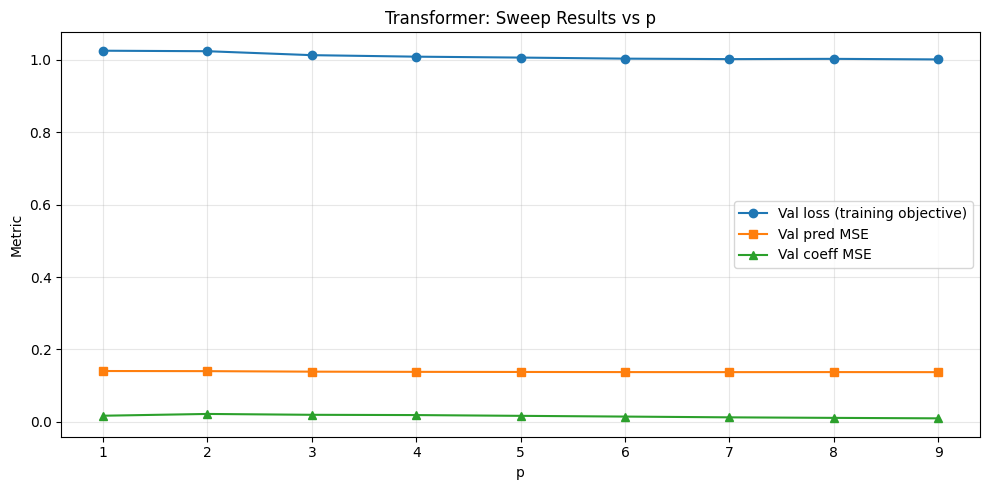

In [12]:
# Plot sweep results
plot_mse_over_p(df, title="Transformer: Sweep Results vs p")

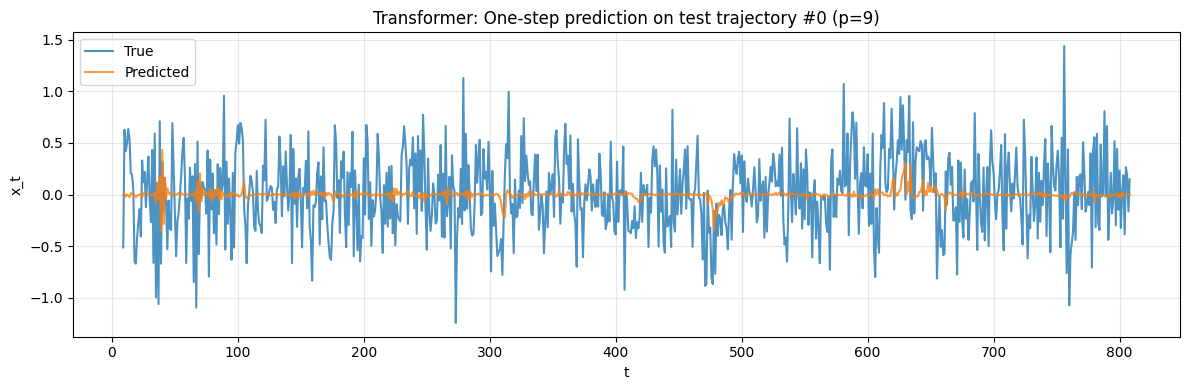

In [13]:
# Visualize predictions on a test trajectory
best_pack = out["best_pack"]
plot_pred_vs_true_signal(best_pack, test_ds, traj_index=0, max_points=800)

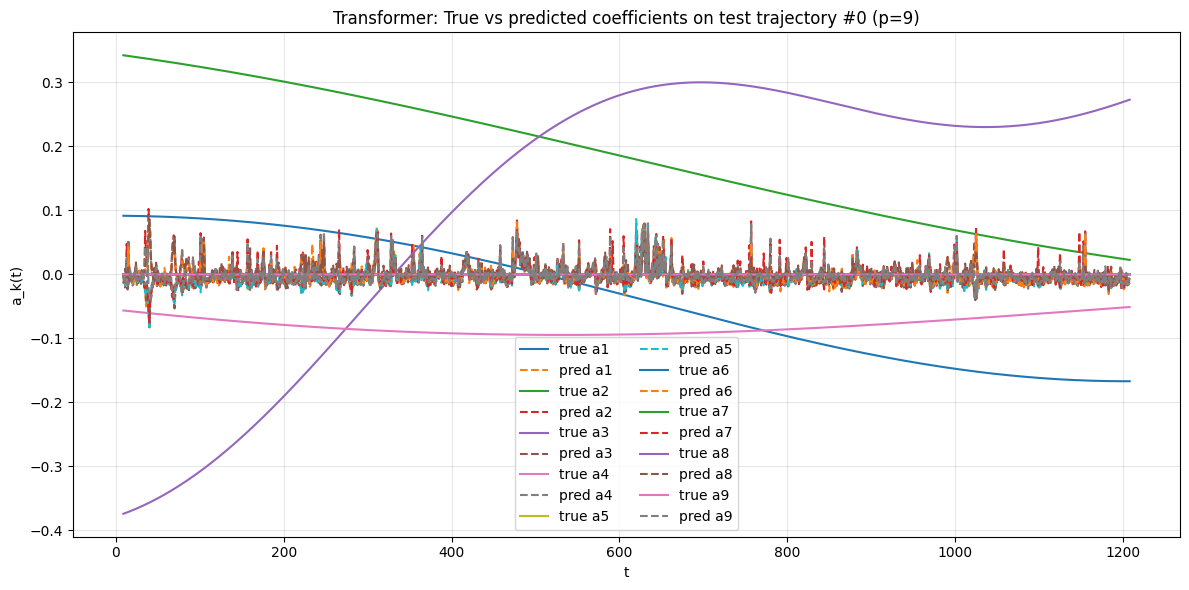

In [14]:
# Plot coefficient tracking
plot_coeff_trajectories(best_pack, test_ds, traj_index=0, max_points=1200)

In [15]:
# Per-trajectory p_hat selection
p_list = list(range(1, 10))
packs = out["packs"]

p_hat_test, mse_mat_test = per_trajectory_phat(packs, test_ds, p_list)

print("p_hat (test):", p_hat_test)
print("p_true (test):", test_ds["p_true"])
print(f"\nAccuracy: {np.mean(p_hat_test == test_ds['p_true']):.2%}")

p_hat (test): [7 5 7 4 9 9 7 3 1 5 7 6 1 1 4 7]
p_true (test): [4 4 4 2 4 6 4 4 1 4 6 2 1 1 2 2]

Accuracy: 18.75%


## Compare with MLP Baseline (Optional)

If you want to compare with the MLP model, you can load the MLP results or run both models and compare.

In [16]:
# ============================================================
# MLP Baseline for comparison
# ============================================================

class MLPCoeffAR(nn.Module):
    """MLP baseline from tvar_mlp_benchmark_sweep_p.ipynb"""
    def __init__(self, p, hidden=128, depth=3, dropout=0.05):
        super().__init__()
        layers = []
        in_dim = p
        for _ in range(depth):
            layers += [
                nn.Linear(in_dim, hidden),
                nn.GELU(),
                nn.LayerNorm(hidden),
                nn.Dropout(dropout),
            ]
            in_dim = hidden
        self.backbone = nn.Sequential(*layers)
        self.coeff_head = nn.Linear(hidden, p)
        self.bias_head = nn.Linear(hidden, 1)

    def forward(self, Zs):
        h = self.backbone(Zs)
        coeffs_s = self.coeff_head(h)
        bias_s = self.bias_head(h).squeeze(-1)
        yhat_s = (coeffs_s * Zs).sum(dim=1) + bias_s
        return yhat_s, coeffs_s, bias_s


def fit_mlp_for_p(
    train_ds, val_ds, p,
    hidden=128, depth=3, dropout=0.05,
    batch_size=512, epochs=30, lr=2e-3, weight_decay=1e-4,
    coeff_loss_w=0.2, l1_out_w=1e-6,
    patience=5, seed=0, verbose=False,
):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    torch.manual_seed(seed)
    t0 = time.perf_counter()

    Z_tr, y_tr, a_tr, _, _ = make_windows_for_p(train_ds, p)
    Z_va, y_va, a_va, _, _ = make_windows_for_p(val_ds, p)

    Z_mean = Z_tr.mean(axis=0, keepdims=True)
    Z_std = Z_tr.std(axis=0, keepdims=True) + 1e-8
    y_mean = y_tr.mean()
    y_std = y_tr.std() + 1e-8

    Z_tr_s = (Z_tr - Z_mean) / Z_std
    Z_va_s = (Z_va - Z_mean) / Z_std
    y_tr_s = (y_tr - y_mean) / y_std
    y_va_s = (y_va - y_mean) / y_std
    a_tr_s = a_tr * (Z_std.reshape(-1) / y_std)
    a_va_s = a_va * (Z_std.reshape(-1) / y_std)

    tr_loader = DataLoader(
        TensorDataset(
            torch.tensor(Z_tr_s, dtype=torch.float32),
            torch.tensor(y_tr_s, dtype=torch.float32),
            torch.tensor(a_tr_s, dtype=torch.float32),
        ),
        batch_size=batch_size, shuffle=True
    )
    va_loader = DataLoader(
        TensorDataset(
            torch.tensor(Z_va_s, dtype=torch.float32),
            torch.tensor(y_va_s, dtype=torch.float32),
            torch.tensor(a_va_s, dtype=torch.float32),
        ),
        batch_size=batch_size, shuffle=False
    )

    model = MLPCoeffAR(p=p, hidden=hidden, depth=depth, dropout=dropout).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    mse = nn.MSELoss()

    best_val = float("inf")
    best_state = None
    bad = 0

    for epoch in range(1, epochs + 1):
        model.train()
        for Zb, yb, ab in tr_loader:
            Zb, yb, ab = Zb.to(device), yb.to(device), ab.to(device)
            yhat_s, coeffs_s, bias_s = model(Zb)
            loss = mse(yhat_s, yb) + coeff_loss_w * mse(coeffs_s, ab) + l1_out_w * coeffs_s.abs().mean()
            opt.zero_grad()
            loss.backward()
            opt.step()

        model.eval()
        va_loss = 0.0
        with torch.no_grad():
            for Zb, yb, ab in va_loader:
                Zb, yb, ab = Zb.to(device), yb.to(device), ab.to(device)
                yhat_s, coeffs_s, bias_s = model(Zb)
                loss = mse(yhat_s, yb) + coeff_loss_w * mse(coeffs_s, ab) + l1_out_w * coeffs_s.abs().mean()
                va_loss += float(loss.item()) * Zb.size(0)
        va_loss /= len(va_loader.dataset)

        if va_loss < best_val - 1e-6:
            best_val = va_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)

    return {
        "p": int(p), "model": model, "device": device,
        "Z_mean": Z_mean.astype(np.float32), "Z_std": Z_std.astype(np.float32),
        "y_mean": float(y_mean), "y_std": float(y_std),
        "best_val": float(best_val), "runtime_s": float(time.perf_counter() - t0),
    }


def eval_mlp_for_p(pack, test_ds):
    p = pack["p"]
    model = pack["model"]
    device = pack["device"]
    Z_mean, Z_std = pack["Z_mean"], pack["Z_std"]
    y_mean, y_std = pack["y_mean"], pack["y_std"]

    Z_te, y_te, a_te, _, _ = make_windows_for_p(test_ds, p)
    Z_te_s = (Z_te - Z_mean) / Z_std

    model.eval()
    with torch.no_grad():
        Zt = torch.tensor(Z_te_s, dtype=torch.float32).to(device)
        yhat_s, coeffs_s, _ = model(Zt)
        yhat_s, coeffs_s = yhat_s.cpu().numpy(), coeffs_s.cpu().numpy()

    yhat = yhat_s * y_std + y_mean
    a_hat = coeffs_s * (y_std / Z_std.reshape(-1))

    return {"p": p, "pred_mse": float(np.mean((yhat - y_te)**2)), 
            "coeff_mse": float(np.mean((a_hat - a_te)**2))}

In [17]:
# Run MLP baseline for comparison
print("Training MLP baseline...")
mlp_packs = {}
mlp_rows = []

t0 = time.perf_counter()
for p in p_list:
    print(f"  MLP p={p}...")
    pack = fit_mlp_for_p(train_ds, val_ds, p, hidden=128, depth=2, dropout=0.05,
                         batch_size=512, epochs=30, lr=2e-3, coeff_loss_w=0.2, patience=5, seed=0)
    # Evaluate on VALIDATION set for model selection
    val_metrics = eval_mlp_for_p(pack, val_ds)
    mlp_packs[p] = pack
    mlp_rows.append({
        "p": p,
        "val_loss": pack["best_val"],
        "val_pred_mse": val_metrics["pred_mse"],
        "val_coeff_mse": val_metrics["coeff_mse"],
        "runtime_s": pack["runtime_s"],
    })

mlp_df = pd.DataFrame(mlp_rows).sort_values("p").reset_index(drop=True)
mlp_best_p = int(mlp_df.loc[mlp_df["val_pred_mse"].idxmin(), "p"])


# Compute TEST metrics only for best modelmlp_df

mlp_test_metrics = eval_mlp_for_p(mlp_packs[mlp_best_p], test_ds)print(f"MLP TEST metrics: pred_mse={mlp_test_metrics['pred_mse']:.6f}, coeff_mse={mlp_test_metrics['coeff_mse']:.6f}")

print(f"\nMLP Total runtime: {time.perf_counter() - t0:.1f}s, Best p: {mlp_best_p}")

SyntaxError: invalid syntax (3081696650.py, line 28)

In [ ]:
# Compare Transformer vs MLP (VALIDATION metrics for model selection)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Val loss (training objective)
axes[0].plot(df["p"], df["val_loss"], marker="o", label="Transformer")
axes[0].plot(mlp_df["p"], mlp_df["val_loss"], marker="s", label="MLP")
axes[0].set_xlabel("p")
axes[0].set_ylabel("Val Loss")
axes[0].set_title("Validation Loss (Training Objective)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Validation prediction MSE
axes[1].plot(df["p"], df["val_pred_mse"], marker="o", label="Transformer")
axes[1].plot(mlp_df["p"], mlp_df["val_pred_mse"], marker="s", label="MLP")
axes[1].set_xlabel("p")
axes[1].set_ylabel("Val Pred MSE")
axes[1].set_title("Validation Prediction MSE")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Validation coefficient MSE
axes[2].plot(df["p"], df["val_coeff_mse"], marker="o", label="Transformer")
axes[2].plot(mlp_df["p"], mlp_df["val_coeff_mse"], marker="s", label="MLP")
axes[2].set_xlabel("p")
axes[2].set_ylabel("Val Coeff MSE")
axes[2].set_title("Validation Coefficient MSE")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary table - FINAL TEST METRICS (only for best models)
print("\n" + "="*80)
print("SUMMARY: Best models selected by val_pred_mse, evaluated on TEST set")
print("="*80)
print(f"{'Model':<15} {'Best p':<10} {'Val Pred MSE':<15} {'TEST Pred MSE':<15} {'TEST Coeff MSE':<15}")
print("-"*80)

tf_best_val = df[df["p"] == out["best_p"]].iloc[0]
mlp_best_val = mlp_df[mlp_df["p"] == mlp_best_p].iloc[0]

print(f"{'Transformer':<15} {out['best_p']:<10} {tf_best_val['val_pred_mse']:<15.6f} {out['test_metrics']['pred_mse']:<15.6f} {out['test_metrics']['coeff_mse']:<15.6f}")
print(f"{'MLP':<15} {mlp_best_p:<10} {mlp_best_val['val_pred_mse']:<15.6f} {mlp_test_metrics['pred_mse']:<15.6f} {mlp_test_metrics['coeff_mse']:<15.6f}")